In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import requests

## API fetching and DataFrame creation 

In [14]:

# Define date range
start_date = datetime(2025, 7, 25)
end_date = datetime(2025, 7, 26)
culture = "pt-PT"
url = "https://servicebus.ren.pt/datahubapi/electricity/ElectricityMarketPricesDaily"

 
pt_data = []

# Loop through each date
current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime('%Y-%m-%d')
    
    params = {
        "culture": culture,
        "date": date_str
    }

    try:
        print(f"Fetching PT data for {date_str}...")
        response = requests.get(url, params=params)
        response.raise_for_status()
        json_data = response.json()

        # Get hours and PT prices
        hours = json_data["xAxis"]["categories"]

        pt_series = next(s for s in json_data["series"] if s["name"] == "PT")
        pt_prices = pt_series["data"]

        # Build rows
        for hour_str, price in zip(hours, pt_prices):
            pt_data.append({
                "Date": date_str,
                "Hour": int(hour_str),
                "Price_PT_€/MWh": price
            })

    except Exception as e:
        print(f"Error fetching data for {date_str}: {e}")

    current_date += timedelta(days=1)


# Create DataFrame
df_pt = pd.DataFrame(pt_data)



# Save to file
df_pt.to_csv("REN_PT_prices.csv", index=False)
# df_pt.to_excel("REN_PT_prices.xlsx", index=False)

Fetching PT data for 2025-07-25...
Fetching PT data for 2025-07-26...


In [15]:
print(df_pt)

          Date  Hour  Price_PT_€/MWh
0   2025-07-25     1           73.63
1   2025-07-25     2           65.95
2   2025-07-25     3           62.00
3   2025-07-25     4           58.99
4   2025-07-25     5           51.97
5   2025-07-25     6           63.43
6   2025-07-25     7           65.95
7   2025-07-25     8           76.00
8   2025-07-25     9           58.99
9   2025-07-25    10           12.75
10  2025-07-25    11            2.51
11  2025-07-25    12            0.65
12  2025-07-25    13            0.75
13  2025-07-25    14            0.85
14  2025-07-25    15            1.10
15  2025-07-25    16            2.51
16  2025-07-25    17            4.31
17  2025-07-25    18            0.65
18  2025-07-25    19            4.31
19  2025-07-25    20           30.85
20  2025-07-25    21           85.00
21  2025-07-25    22          104.72
22  2025-07-25    23          101.94
23  2025-07-25    24           79.99
24  2025-07-26     1           96.27
25  2025-07-26     2           77.16
2

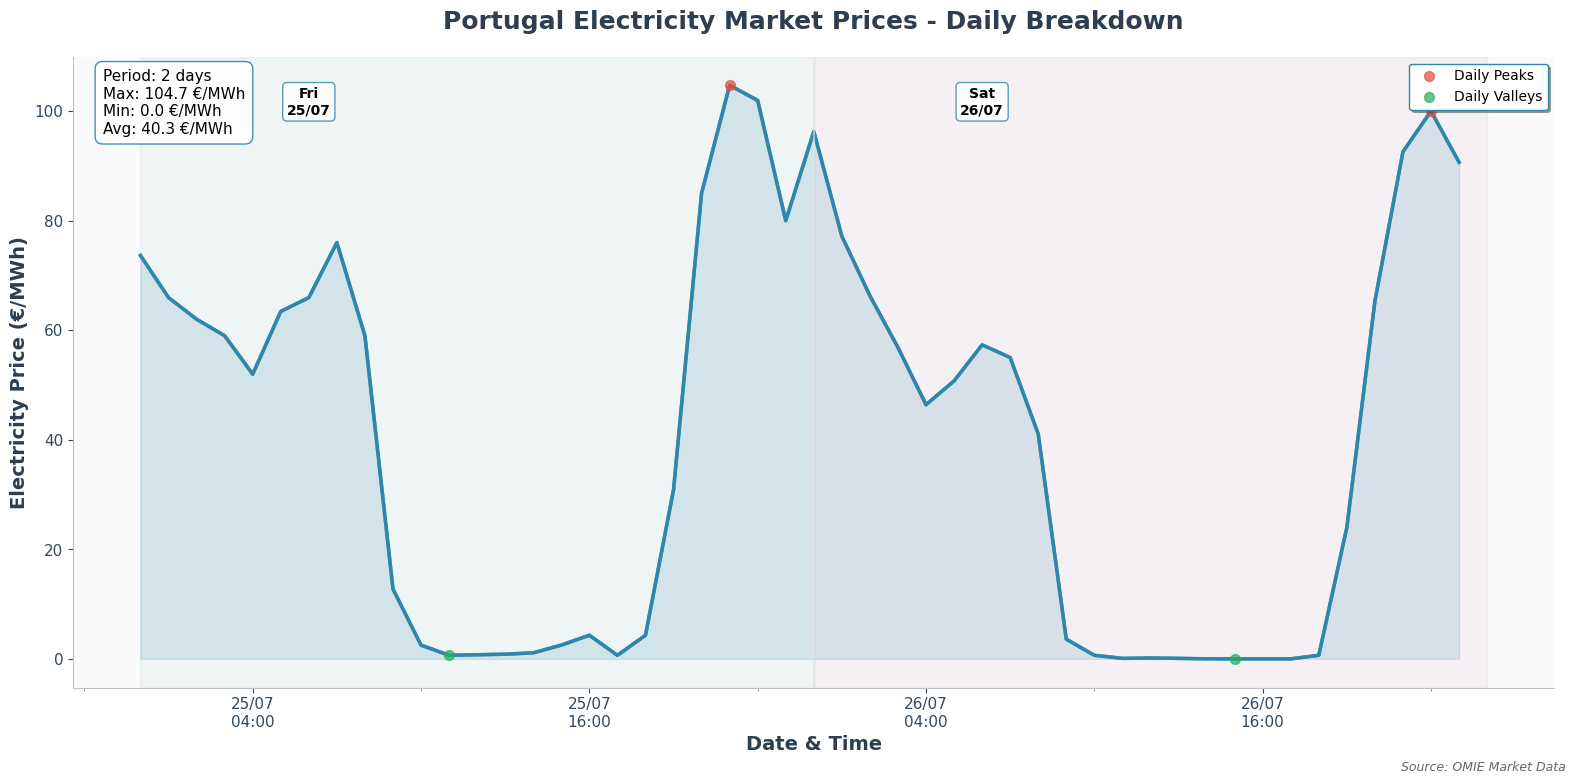


=== DAILY PRICE ANALYSIS ===


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

hour = df_pt['Hour'] - 1
hour = [min(h, 23) for h in hour]
date = df_pt['Date']
dt = [datetime.strptime(date[i], "%Y-%m-%d").replace(hour=int(hour[i])) for i in range(len(date))]

price = df_pt['Price_PT_€/MWh']

# Create figure with enhanced styling
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 8), facecolor='white')

# Colorscheme
primary_color = '#2E86AB'
separator_color = '#E8E8E8'
bg_color = '#FAFAFA'

# Set background
ax.set_facecolor(bg_color)

# Get unique dates for day separations
unique_dates = sorted(set(d.date() for d in dt))

# Plot vertical lines to separate days
for i, day in enumerate(unique_dates[1:], 1):  # Skip first day
    day_start = datetime.combine(day, datetime.min.time())
    ax.axvline(x=day_start, color=separator_color, linewidth=1.5, alpha=0.6, zorder=4)

# Plot the main price line
ax.plot(dt, price, linewidth=2.5, color=primary_color, alpha=0.9, zorder=3)

# Add background color bands for each day (full day width)
y_min, y_max = ax.get_ylim() if ax.get_ylim() != (0.0, 1.0) else (0, max(price) * 1.1)

for i, day in enumerate(unique_dates):
    day_start = datetime.combine(day, datetime.min.time())
    day_end = day_start + timedelta(days=1)
    
    # Alternate background colors for better day distinction
    fill_color = primary_color if i % 2 == 0 else '#A23B72'
    
    # Create full-height background bands
    ax.axvspan(day_start, day_end, alpha=0.05, color=fill_color, zorder=0)

# Plot the main price line (moved after background)
ax.plot(dt, price, linewidth=2.5, color=primary_color, alpha=0.9, zorder=3)

# Add subtle area fill under the line
ax.fill_between(dt, price, alpha=0.15, color=primary_color, zorder=2)

# Labels and title
ax.set_xlabel("Date & Time", fontsize=14, fontweight='600', color='#2C3E50')
ax.set_ylabel("Electricity Price (€/MWh)", fontsize=14, fontweight='600', color='#2C3E50')
ax.set_title("Portugal Electricity Market Prices - Daily Breakdown", 
             fontsize=18, fontweight='bold', color='#2C3E50', pad=20)

# Enhanced date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m\n%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Every 12 hours
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))   # Every 6 hours

# Rotate labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=10)

# Style improvements
ax.tick_params(axis='both', which='major', labelsize=11, colors='#34495E')
ax.tick_params(axis='both', which='minor', labelsize=9, colors='#7F8C8D')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')

# Add day labels at the top
for i, day in enumerate(unique_dates):
    day_start = datetime.combine(day, datetime.min.time())
    # Position label at 6 AM of each day for better visibility
    label_time = day_start + timedelta(hours=6)
    
    # Only add label if this time exists in our data range
    if any(abs((d - label_time).total_seconds()) < 3600 for d in dt):
        ax.text(label_time, ax.get_ylim()[1] * 0.95, 
                day.strftime('%a\n%d/%m'), 
                ha='center', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
                         edgecolor=primary_color, alpha=0.8))

# Add statistics
price_stats = {
    'Max': price.max(),
    'Min': price.min(),
    'Avg': price.mean(),
    'Days': len(unique_dates)
}

stats_text = f"Period: {len(unique_dates)} days\nMax: {price_stats['Max']:.1f} €/MWh\nMin: {price_stats['Min']:.1f} €/MWh\nAvg: {price_stats['Avg']:.1f} €/MWh"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
        facecolor='white', edgecolor=primary_color, alpha=0.9))

# Highlight peak and valley points for each day
daily_peaks = []
daily_valleys = []

for day in unique_dates:
    day_data = [(d, p, i) for i, (d, p) in enumerate(zip(dt, price)) if d.date() == day]
    if day_data:
        day_prices = [p for _, p, _ in day_data]
        max_idx = day_data[np.argmax(day_prices)][2]
        min_idx = day_data[np.argmin(day_prices)][2]
        daily_peaks.append((dt[max_idx], price[max_idx]))
        daily_valleys.append((dt[min_idx], price[min_idx]))

# Plot daily peaks and valleys
peak_times, peak_prices = zip(*daily_peaks)
valley_times, valley_prices = zip(*daily_valleys)

ax.scatter(peak_times, peak_prices, color='#E74C3C', s=50, zorder=5, 
           alpha=0.7, label='Daily Peaks')
ax.scatter(valley_times, valley_prices, color='#27AE60', s=50, zorder=5,
           alpha=0.7, label='Daily Valleys')

# Add legend
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
          fontsize=10, facecolor='white', edgecolor=primary_color)

# Adjust layout
plt.tight_layout(pad=2.0)

# Add source
fig.text(0.99, 0.01, 'Source: OMIE Market Data', ha='right', va='bottom', 
         fontsize=9, alpha=0.6, style='italic')

plt.show()

# Print summary statistics by day
print("\n=== DAILY PRICE ANALYSIS ===")
for i, day in enumerate(unique_dates):
    day_data = [p for d, p in zip(dt, price) if d.date() == day]
    if day_data:
        daily_max = max(day_data)
        daily_min = min(day_data)
        daily_avg = sum(day_data) / len(day_data)
        daily_spread = daily_max - daily_min
  

In [19]:
"""
Professional Electricity Market Price Analyzer
==============================================

A comprehensive tool for analyzing and visualizing electricity market prices
with advanced statistical analysis and professional-grade visualizations.

Author: Market Analytics Team
Version: 2.0
License: MIT
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from typing import List, Tuple, Dict, Optional
import warnings

# Suppress matplotlib warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')


class ElectricityPriceAnalyzer:
    """
    Professional electricity price analysis and visualization toolkit.
    
    This class provides comprehensive analysis of electricity market data including
    price trends, volatility analysis, peak/valley detection, and statistical reporting.
    """
    
    def __init__(self, df: pd.DataFrame, country_column: str = 'Portugal'):
        """
        Initialize the analyzer with market data.
        
        Args:
            df: DataFrame containing 'Data', 'Hora', and price columns
            country_column: Name of the column containing price data
        """
        self.df = df.copy()
        self.country_column = country_column
        self.dt, self.prices = self._prepare_data()
        self.unique_dates = sorted(set(d.date() for d in self.dt))
        
        # Professional color palette
        self.colors = {
            'primary': '#1f77b4',      # Professional blue
            'secondary': '#ff7f0e',    # Accent orange
            'success': '#2ca02c',      # Success green
            'danger': '#d62728',       # Alert red
            'warning': '#ff9500',      # Warning amber
            'neutral': '#7f7f7f',      # Neutral gray
            'background': '#f8f9fa',   # Light background
            'separator': '#dee2e6',    # Light separator
            'text': '#212529'          # Dark text
        }
    
    def _prepare_data(self) -> Tuple[List[datetime], pd.Series]:
        """
        Prepare datetime series and price data from raw DataFrame.
        
        Returns:
            Tuple of datetime list and price series
        """
        hour = self.df['Hora'] - 1
        date = self.df['Data']
        
        dt = [
            datetime.strptime(date.iloc[i], "%Y-%m-%d").replace(hour=int(hour.iloc[i])) 
            for i in range(len(date))
        ]
        
        return dt, self.df[self.country_column]
    
    def calculate_daily_statistics(self) -> pd.DataFrame:
        """
        Calculate comprehensive daily statistics.
        
        Returns:
            DataFrame with daily statistics including OHLC, volatility, and spread metrics
        """
        daily_stats = []
        
        for day in self.unique_dates:
            day_data = [p for d, p in zip(self.dt, self.prices) if d.date() == day]
            
            if day_data:
                stats = {
                    'date': day,
                    'day_name': day.strftime('%A'),
                    'open': day_data[0],
                    'high': max(day_data),
                    'low': min(day_data),
                    'close': day_data[-1],
                    'mean': np.mean(day_data),
                    'median': np.median(day_data),
                    'std': np.std(day_data),
                    'spread': max(day_data) - min(day_data),
                    'volatility': (np.std(day_data) / np.mean(day_data)) * 100,
                    'data_points': len(day_data)
                }
                daily_stats.append(stats)
        
        return pd.DataFrame(daily_stats)
    
    def detect_peaks_valleys(self) -> Tuple[List[Tuple], List[Tuple]]:
        """
        Detect daily peaks and valleys with enhanced algorithms.
        
        Returns:
            Tuple of (peaks, valleys) as lists of (datetime, price) tuples
        """
        daily_peaks = []
        daily_valleys = []
        
        for day in self.unique_dates:
            day_indices = [i for i, d in enumerate(self.dt) if d.date() == day]
            
            if day_indices:
                day_prices = [self.prices.iloc[i] for i in day_indices]
                
                # Find peaks and valleys using local maxima/minima
                peak_idx = day_indices[np.argmax(day_prices)]
                valley_idx = day_indices[np.argmin(day_prices)]
                
                daily_peaks.append((self.dt[peak_idx], self.prices.iloc[peak_idx]))
                daily_valleys.append((self.dt[valley_idx], self.prices.iloc[valley_idx]))
        
        return daily_peaks, daily_valleys
    
    def create_professional_visualization(self, 
                                        figsize: Tuple[int, int] = (16, 10),
                                        show_statistics: bool = True,
                                        show_peaks_valleys: bool = True,
                                        export_path: Optional[str] = None) -> plt.Figure:
        """
        Create a professional-grade visualization of electricity prices.
        
        Args:
            figsize: Figure size as (width, height)
            show_statistics: Whether to display statistics panel
            show_peaks_valleys: Whether to highlight daily peaks and valleys
            export_path: Path to save the figure (optional)
            
        Returns:
            matplotlib Figure object
        """
        # Set professional style
        try:
            plt.style.use('seaborn-v0_8-whitegrid')
        except OSError:
            plt.style.use('seaborn-whitegrid')
        sns.set_palette("husl")
        
        fig = plt.figure(figsize=figsize, facecolor='white', dpi=100)
        
        # Create main subplot
        ax_main = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
        
        # Set professional background
        ax_main.set_facecolor(self.colors['background'])
        
        # Plot day separators
        self._add_day_separators(ax_main)
        
        # Plot main price line with gradient fill
        self._plot_price_line(ax_main)
        
        # Add peaks and valleys if requested
        if show_peaks_valleys:
            self._add_peaks_valleys(ax_main)
        
        # Configure axes and styling
        self._configure_main_axes(ax_main)
        
        # Add day labels
        self._add_day_labels(ax_main)
        
        # Add statistics panel if requested
        if show_statistics:
            ax_stats = plt.subplot2grid((4, 4), (3, 0), colspan=2)
            self._add_statistics_panel(ax_stats)
            
            ax_dist = plt.subplot2grid((4, 4), (3, 2), colspan=2)
            self._add_distribution_plot(ax_dist)
        
        # Final layout adjustments
        plt.tight_layout(pad=3.0)
        
        # Add professional footer
        self._add_footer(fig)
        
        # Export if path provided
        if export_path:
            fig.savefig(export_path, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"Figure exported to: {export_path}")
        
        return fig
    
    def _add_day_separators(self, ax: plt.Axes) -> None:
        """Add vertical lines to separate days."""
        for day in self.unique_dates[1:]:
            day_start = datetime.combine(day, datetime.min.time())
            ax.axvline(x=day_start, color=self.colors['separator'], 
                      linewidth=1, alpha=0.8, zorder=1)
    
    def _plot_price_line(self, ax: plt.Axes) -> None:
        """Plot the main price line with enhanced styling."""
        # Main line plot
        line = ax.plot(self.dt, self.prices, linewidth=2.5, 
                      color=self.colors['primary'], alpha=0.9, 
                      zorder=3, label='Market Price')[0]
        
        # Add gradient fill
        ax.fill_between(self.dt, self.prices, alpha=0.2, 
                       color=self.colors['primary'], zorder=2)
        
        # Add moving average if enough data points
        if len(self.prices) > 24:
            ma_window = min(24, len(self.prices) // 4)
            moving_avg = self.prices.rolling(window=ma_window, center=True).mean()
            ax.plot(self.dt, moving_avg, '--', linewidth=2, 
                   color=self.colors['secondary'], alpha=0.7, 
                   label=f'{ma_window}h Moving Average')
    
    def _add_peaks_valleys(self, ax: plt.Axes) -> None:
        """Add peak and valley markers."""
        peaks, valleys = self.detect_peaks_valleys()
        
        if peaks:
            peak_times, peak_prices = zip(*peaks)
            ax.scatter(peak_times, peak_prices, 
                      color=self.colors['danger'], s=80, zorder=5,
                      alpha=0.8, marker='^', label='Daily Peaks',
                      edgecolors='white', linewidth=1)
        
        if valleys:
            valley_times, valley_prices = zip(*valleys)
            ax.scatter(valley_times, valley_prices,
                      color=self.colors['success'], s=80, zorder=5,
                      alpha=0.8, marker='v', label='Daily Valleys',
                      edgecolors='white', linewidth=1)
    
    def _configure_main_axes(self, ax: plt.Axes) -> None:
        """Configure main axes styling and labels."""
        # Labels and title
        ax.set_xlabel("Date & Time", fontsize=12, fontweight='600', 
                     color=self.colors['text'])
        ax.set_ylabel("Price (€/MWh)", fontsize=12, fontweight='600', 
                     color=self.colors['text'])
        
        title = f"Electricity Market Analysis - {self.country_column}"
        subtitle = f"Period: {self.unique_dates[0].strftime('%d/%m/%Y')} to {self.unique_dates[-1].strftime('%d/%m/%Y')}"
        ax.set_title(f"{title}\n{subtitle}", fontsize=16, fontweight='bold', 
                    color=self.colors['text'], pad=20)
        
        # Date formatting
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m\n%H:%M'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
        
        # Tick styling
        ax.tick_params(axis='both', which='major', labelsize=10, 
                      colors=self.colors['text'])
        ax.tick_params(axis='both', which='minor', labelsize=8, 
                      colors=self.colors['neutral'])
        
        # Spine styling
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(self.colors['neutral'])
        
        # Grid styling
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        # Legend
        legend = ax.legend(loc='upper left', frameon=True, fancybox=True, 
                          shadow=True, fontsize=10, facecolor='white', 
                          edgecolor=self.colors['primary'])
        legend.get_frame().set_alpha(0.9)
    
    def _add_day_labels(self, ax: plt.Axes) -> None:
        """Add day labels at the top of the chart."""
        y_pos = ax.get_ylim()[1] * 0.95
        
        for day in self.unique_dates:
            day_start = datetime.combine(day, datetime.min.time())
            label_time = day_start + timedelta(hours=12)
            
            ax.text(label_time, y_pos, 
                   day.strftime('%a\n%d/%m'), 
                   ha='center', va='top', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", 
                           facecolor='white', 
                           edgecolor=self.colors['primary'], 
                           alpha=0.8))
    
    def _add_statistics_panel(self, ax: plt.Axes) -> None:
        """Add a statistics panel showing key metrics."""
        stats = self.calculate_daily_statistics()
        
        # Create summary statistics
        summary_stats = {
            'Period': f"{len(self.unique_dates)} days",
            'Max Price': f"{self.prices.max():.1f} €/MWh",
            'Min Price': f"{self.prices.min():.1f} €/MWh",
            'Avg Price': f"{self.prices.mean():.1f} €/MWh",
            'Std Dev': f"{self.prices.std():.1f} €/MWh",
            'Avg Daily Spread': f"{stats['spread'].mean():.1f} €/MWh"
        }
        
        # Create text for display
        stats_text = '\n'.join([f"{k}: {v}" for k, v in summary_stats.items()])
        
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.5", 
                        facecolor=self.colors['background'], 
                        edgecolor=self.colors['primary'], 
                        alpha=0.9))
        
        ax.set_title("Key Statistics", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    def _add_distribution_plot(self, ax: plt.Axes) -> None:
        """Add a price distribution histogram."""
        ax.hist(self.prices, bins=30, alpha=0.7, 
               color=self.colors['primary'], edgecolor='white')
        ax.set_xlabel("Price (€/MWh)", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.set_title("Price Distribution", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    def _add_footer(self, fig: plt.Figure) -> None:
        """Add professional footer with metadata."""
        footer_text = (
            f"Generated: {datetime.now().strftime('%d/%m/%Y %H:%M')} | "
            f"Data Points: {len(self.prices)} | "
            f"Source: OMIE Market Data"
        )
        fig.text(0.99, 0.01, footer_text, ha='right', va='bottom', 
                fontsize=8, alpha=0.6, style='italic')
    
    def generate_report(self) -> str:
        """
        Generate a comprehensive text report of the analysis.
        
        Returns:
            Formatted string report
        """
        stats = self.calculate_daily_statistics()
        
        report = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                     ELECTRICITY MARKET ANALYSIS REPORT              ║
║                            {self.country_column} Market                           ║
╚══════════════════════════════════════════════════════════════════════╝

📊 OVERVIEW
═══════════
• Analysis Period: {self.unique_dates[0].strftime('%d/%m/%Y')} to {self.unique_dates[-1].strftime('%d/%m/%Y')}
• Total Days: {len(self.unique_dates)}
• Data Points: {len(self.prices)}
• Market: {self.country_column}

💰 PRICE STATISTICS
═══════════════════
• Maximum Price: {self.prices.max():.2f} €/MWh
• Minimum Price: {self.prices.min():.2f} €/MWh
• Average Price: {self.prices.mean():.2f} €/MWh
• Median Price: {self.prices.median():.2f} €/MWh
• Standard Deviation: {self.prices.std():.2f} €/MWh
• Price Range: {self.prices.max() - self.prices.min():.2f} €/MWh

📈 DAILY BREAKDOWN
═══════════════════
"""
        
        for _, day_stats in stats.iterrows():
            report += (
                f"• {day_stats['day_name']} ({day_stats['date'].strftime('%d/%m')}):\n"
                f"  Range: {day_stats['low']:.1f} - {day_stats['high']:.1f} €/MWh | "
                f"Avg: {day_stats['mean']:.1f} €/MWh | "
                f"Spread: {day_stats['spread']:.1f} €/MWh | "
                f"Volatility: {day_stats['volatility']:.1f}%\n"
            )
        
        report += f"""
📊 VOLATILITY ANALYSIS
══════════════════════
• Average Daily Spread: {stats['spread'].mean():.2f} €/MWh
• Maximum Daily Spread: {stats['spread'].max():.2f} €/MWh
• Average Daily Volatility: {stats['volatility'].mean():.2f}%
• Most Volatile Day: {stats.loc[stats['volatility'].idxmax(), 'day_name']} ({stats['volatility'].max():.2f}%)
• Most Stable Day: {stats.loc[stats['volatility'].idxmin(), 'day_name']} ({stats['volatility'].min():.2f}%)

═══════════════════════════════════════════════════════════════════════
Report generated on {datetime.now().strftime('%d/%m/%Y at %H:%M')}
Data source: OMIE Market Data
═══════════════════════════════════════════════════════════════════════
"""
        
        return report


# Example usage and main execution
def main():
    """
    Main execution function demonstrating the analyzer usage.
    
    Note: This assumes 'df' variable exists with the required columns.
    """
    # Initialize the analyzer
    # analyzer = ElectricityPriceAnalyzer(df, 'Portugal')
    
    # Create professional visualization
    # fig = analyzer.create_professional_visualization(
    #     figsize=(16, 10),
    #     show_statistics=True,
    #     show_peaks_valleys=True,
    #     export_path='electricity_analysis.png'
    # )
    
    # Generate and print comprehensive report
    # report = analyzer.generate_report()
    # print(report)
    
    # Display the plot
    # plt.show()
    
    pass


if __name__ == "__main__":
    # Uncomment the following lines when you have your DataFrame ready:
    # analyzer = ElectricityPriceAnalyzer(df, 'Portugal')
    # fig = analyzer.create_professional_visualization()
    # print(analyzer.generate_report())
    # plt.show()
    
    print("Professional Electricity Price Analyzer ready to use!")
    print("Initialize with: analyzer = ElectricityPriceAnalyzer(df, 'Portugal')")
    print("Create visualization: analyzer.create_professional_visualization()")

Professional Electricity Price Analyzer ready to use!
Initialize with: analyzer = ElectricityPriceAnalyzer(df, 'Portugal')
Create visualization: analyzer.create_professional_visualization()


In [ ]:
"""
Real-Time Battery Energy Storage System (BESS) Optimization
===========================================================

Real-time optimization strategies for battery energy storage systems that make
decisions using only current and historical data - no future price knowledge required.

Features:
- Moving average strategies
- Momentum-based trading
- Adaptive threshold strategies  
- Online learning algorithms
- Real-time risk management

Author: Real-Time Trading Team
Version: 1.0
License: MIT
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from typing import List, Tuple, Dict, Optional, NamedTuple
from dataclasses import dataclass
from collections import deque
import warnings

warnings.filterwarnings('ignore')


@dataclass
class BatterySpecs:
    """Battery technical specifications."""
    capacity_mwh: float = 10.0          # Battery capacity in MWh
    power_rating_mw: float = 5.0        # Maximum power in MW
    efficiency: float = 0.90            # Round-trip efficiency (0-1)
    min_soc: float = 0.10              # Minimum state of charge (0-1)
    max_soc: float = 0.95              # Maximum state of charge (0-1)
    degradation_rate: float = 0.0001   # Degradation per cycle
    initial_soc: float = 0.50          # Starting state of charge


@dataclass
class MarketConditions:
    """Market trading conditions and costs."""
    transaction_cost: float = 0.50     # €/MWh transaction cost
    imbalance_penalty: float = 10.0    # €/MWh penalty for imbalances
    grid_connection_fee: float = 100.0 # €/day grid connection
    carbon_price: float = 80.0         # €/tonne CO2
    grid_emission_factor: float = 0.3  # tonne CO2/MWh


class TradingAction(NamedTuple):
    """Represents a single trading action."""
    timestamp: datetime
    action: str  # 'charge', 'discharge', 'idle'
    power_mw: float
    energy_mwh: float
    price: float
    soc_before: float
    soc_after: float
    revenue: float
    cost: float
    net_profit: float
    confidence: float = 1.0  # Strategy confidence level (0-1)


class RealTimeBESSOptimizer:
    """
    Real-time Battery Energy Storage System optimization engine.
    
    Implements real-time strategies that only use current and historical data.
    No future price knowledge required.
    """
    
    def __init__(self, 
                 battery_specs: BatterySpecs = None,
                 market_conditions: MarketConditions = None,
                 lookback_hours: int = 168):  # 1 week default
        """
        Initialize the real-time BESS optimizer.
        
        Args:
            battery_specs: Battery technical specifications
            market_conditions: Market trading conditions
            lookback_hours: Hours of historical data to maintain
        """
        self.battery = battery_specs or BatterySpecs()
        self.market = market_conditions or MarketConditions()
        self.lookback_hours = lookback_hours
        
        # Historical data storage (using deque for efficiency)
        self.price_history = deque(maxlen=lookback_hours)
        self.timestamp_history = deque(maxlen=lookback_hours)
        self.action_history = deque(maxlen=lookback_hours)
        
        # Current state
        self.current_soc = self.battery.initial_soc
        self.current_timestamp = None
        self.current_price = None
        
        # Strategy parameters (adaptive)
        self.strategy_params = {
            'ma_short_period': 6,   # Short moving average (hours)
            'ma_long_period': 24,   # Long moving average (hours)
            'volatility_period': 12, # Volatility calculation period
            'momentum_period': 4,   # Price momentum period
            'confidence_threshold': 0.6,  # Minimum confidence to act
            'risk_factor': 0.8,     # Risk adjustment factor
        }
        
        # Performance tracking
        self.total_revenue = 0.0
        self.total_cost = 0.0
        self.total_cycles = 0
    
    def update_market_data(self, timestamp: datetime, price: float) -> None:
        """
        Update with new market data point.
        
        Args:
            timestamp: Current timestamp
            price: Current electricity price (€/MWh)
        """
        self.current_timestamp = timestamp
        self.current_price = price
        
        # Add to history
        self.price_history.append(price)
        self.timestamp_history.append(timestamp)
    
    def _calculate_moving_averages(self) -> Dict[str, float]:
        """Calculate moving averages from price history."""
        if len(self.price_history) < self.strategy_params['ma_short_period']:
            return {'ma_short': self.current_price, 'ma_long': self.current_price}
        
        prices = list(self.price_history)
        
        ma_short = np.mean(prices[-self.strategy_params['ma_short_period']:])
        
        if len(prices) >= self.strategy_params['ma_long_period']:
            ma_long = np.mean(prices[-self.strategy_params['ma_long_period']:])
        else:
            ma_long = np.mean(prices)
        
        return {'ma_short': ma_short, 'ma_long': ma_long}
    
    def _calculate_volatility(self) -> float:
        """Calculate recent price volatility."""
        if len(self.price_history) < self.strategy_params['volatility_period']:
            return 0.0
        
        prices = list(self.price_history)[-self.strategy_params['volatility_period']:]
        return np.std(prices)
    
    def _calculate_momentum(self) -> float:
        """Calculate price momentum indicator."""
        if len(self.price_history) < self.strategy_params['momentum_period']:
            return 0.0
        
        prices = list(self.price_history)
        recent_prices = prices[-self.strategy_params['momentum_period']:]
        
        if len(recent_prices) < 2:
            return 0.0
        
        # Calculate momentum as rate of change
        momentum = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
        return momentum
    
    def _calculate_percentiles(self) -> Dict[str, float]:
        """Calculate historical price percentiles."""
        if len(self.price_history) < 10:  # Need minimum data
            return {'p25': self.current_price, 'p50': self.current_price, 'p75': self.current_price}
        
        prices = list(self.price_history)
        return {
            'p25': np.percentile(prices, 25),
            'p50': np.percentile(prices, 50),
            'p75': np.percentile(prices, 75)
        }
    
    def moving_average_strategy(self) -> Tuple[str, float, float]:
        """
        Moving average crossover strategy.
        
        Returns:
            Tuple of (action, power_mw, confidence)
        """
        mas = self._calculate_moving_averages()
        ma_short = mas['ma_short']
        ma_long = mas['ma_long']
        
        # Calculate signal strength
        price_vs_ma_short = (self.current_price - ma_short) / ma_short
        ma_spread = (ma_short - ma_long) / ma_long if ma_long > 0 else 0
        
        # Decision logic
        confidence = 0.0
        action = 'idle'
        power_factor = 0.0
        
        # Strong buy signal: price below short MA, short MA below long MA
        if self.current_price < ma_short and ma_short < ma_long:
            if self.current_soc < self.battery.max_soc:
                action = 'charge'
                confidence = min(abs(price_vs_ma_short) + abs(ma_spread), 1.0)
                power_factor = confidence * self.strategy_params['risk_factor']
        
        # Strong sell signal: price above short MA, short MA above long MA  
        elif self.current_price > ma_short and ma_short > ma_long:
            if self.current_soc > self.battery.min_soc:
                action = 'discharge'
                confidence = min(abs(price_vs_ma_short) + abs(ma_spread), 1.0)
                power_factor = confidence * self.strategy_params['risk_factor']
        
        # Calculate power
        max_power = self.battery.power_rating_mw
        power_mw = power_factor * max_power
        
        return action, power_mw, confidence
    
    def momentum_strategy(self) -> Tuple[str, float, float]:
        """
        Momentum-based trading strategy.
        
        Returns:
            Tuple of (action, power_mw, confidence)
        """
        momentum = self._calculate_momentum()
        volatility = self._calculate_volatility()
        percentiles = self._calculate_percentiles()
        
        # Normalize momentum and volatility
        momentum_strength = abs(momentum)
        volatility_factor = min(volatility / 10.0, 1.0)  # Normalize to 0-1
        
        action = 'idle'
        confidence = 0.0
        power_factor = 0.0
        
        # Strong downward momentum + low price = buy opportunity
        if momentum < -0.02 and self.current_price < percentiles['p25']:
            if self.current_soc < self.battery.max_soc:
                action = 'charge'
                confidence = min(momentum_strength + (1 - volatility_factor), 1.0)
                power_factor = confidence * self.strategy_params['risk_factor']
        
        # Strong upward momentum + high price = sell opportunity
        elif momentum > 0.02 and self.current_price > percentiles['p75']:
            if self.current_soc > self.battery.min_soc:
                action = 'discharge'
                confidence = min(momentum_strength + (1 - volatility_factor), 1.0)
                power_factor = confidence * self.strategy_params['risk_factor']
        
        # Calculate power
        max_power = self.battery.power_rating_mw
        power_mw = power_factor * max_power
        
        return action, power_mw, confidence
    
    def adaptive_threshold_strategy(self) -> Tuple[str, float, float]:
        """
        Adaptive threshold strategy that adjusts based on market conditions.
        
        Returns:
            Tuple of (action, power_mw, confidence)
        """
        percentiles = self._calculate_percentiles()
        volatility = self._calculate_volatility()
        
        # Adapt thresholds based on volatility
        volatility_adjustment = min(volatility / 20.0, 0.3)  # Max 30% adjustment
        
        # Calculate adaptive thresholds
        buy_threshold = percentiles['p25'] * (1 + volatility_adjustment)
        sell_threshold = percentiles['p75'] * (1 - volatility_adjustment)
        
        # Calculate distance from thresholds
        buy_distance = max(0, buy_threshold - self.current_price) / buy_threshold
        sell_distance = max(0, self.current_price - sell_threshold) / sell_threshold
        
        action = 'idle'
        confidence = 0.0
        power_factor = 0.0
        
        # Buy signal
        if self.current_price <= buy_threshold and self.current_soc < self.battery.max_soc:
            action = 'charge'
            confidence = min(buy_distance * 2, 1.0)  # Scale confidence
            power_factor = confidence * self.strategy_params['risk_factor']
        
        # Sell signal
        elif self.current_price >= sell_threshold and self.current_soc > self.battery.min_soc:
            action = 'discharge'
            confidence = min(sell_distance * 2, 1.0)  # Scale confidence
            power_factor = confidence * self.strategy_params['risk_factor']
        
        # Calculate power
        max_power = self.battery.power_rating_mw
        power_mw = power_factor * max_power
        
        return action, power_mw, confidence
    
    def ensemble_strategy(self) -> Tuple[str, float, float]:
        """
        Ensemble strategy combining multiple approaches.
        
        Returns:
            Tuple of (action, power_mw, confidence)
        """
        # Get signals from all strategies
        ma_action, ma_power, ma_conf = self.moving_average_strategy()
        momentum_action, momentum_power, momentum_conf = self.momentum_strategy()
        adaptive_action, adaptive_power, adaptive_conf = self.adaptive_threshold_strategy()
        
        # Combine signals
        strategies = [
            (ma_action, ma_power, ma_conf, 0.4),      # 40% weight
            (momentum_action, momentum_power, momentum_conf, 0.3),  # 30% weight
            (adaptive_action, adaptive_power, adaptive_conf, 0.3)   # 30% weight
        ]
        
        # Vote on action
        action_votes = {'charge': 0, 'discharge': 0, 'idle': 0}
        weighted_power = 0.0
        weighted_confidence = 0.0
        
        for action, power, conf, weight in strategies:
            action_votes[action] += weight * conf
            weighted_power += power * weight * conf
            weighted_confidence += conf * weight
        
        # Select action with highest weighted vote
        final_action = max(action_votes.keys(), key=lambda x: action_votes[x])
        
        # Only act if confidence is above threshold
        if weighted_confidence < self.strategy_params['confidence_threshold']:
            final_action = 'idle'
            weighted_power = 0.0
        
        return final_action, weighted_power, weighted_confidence
    
    def make_trading_decision(self, 
                            strategy: str = 'ensemble',
                            time_interval: float = 1.0) -> TradingAction:
        """
        Make a real-time trading decision.
        
        Args:
            strategy: Strategy to use ('ma', 'momentum', 'adaptive', 'ensemble')
            time_interval: Time interval in hours
            
        Returns:
            TradingAction object
        """
        if self.current_price is None or self.current_timestamp is None:
            raise ValueError("Must update market data before making decisions")
        
        # Select strategy
        strategy_map = {
            'ma': self.moving_average_strategy,
            'momentum': self.momentum_strategy,
            'adaptive': self.adaptive_threshold_strategy,
            'ensemble': self.ensemble_strategy
        }
        
        if strategy not in strategy_map:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        action, power_mw, confidence = strategy_map[strategy]()
        
        # Calculate energy and constraints
        energy_mwh = 0.0
        revenue = 0.0
        cost = 0.0
        soc_before = self.current_soc
        
        if action == 'charge':
            # Check SOC and power constraints
            max_energy = min(
                power_mw * time_interval,
                (self.battery.max_soc - self.current_soc) * self.battery.capacity_mwh
            )
            energy_mwh = max_energy
            power_mw = energy_mwh / time_interval if time_interval > 0 else 0
            cost = energy_mwh * (self.current_price + self.market.transaction_cost)
            self.current_soc += energy_mwh / self.battery.capacity_mwh
            
        elif action == 'discharge':
            # Check SOC and power constraints
            max_energy = min(
                power_mw * time_interval,
                (self.current_soc - self.battery.min_soc) * self.battery.capacity_mwh
            )
            energy_mwh = max_energy
            power_mw = energy_mwh / time_interval if time_interval > 0 else 0
            revenue = energy_mwh * (self.current_price - self.market.transaction_cost) * self.battery.efficiency
            self.current_soc -= energy_mwh / self.battery.capacity_mwh
        
        # Create trading action
        trading_action = TradingAction(
            timestamp=self.current_timestamp,
            action=action,
            power_mw=power_mw,
            energy_mwh=energy_mwh,
            price=self.current_price,
            soc_before=soc_before,
            soc_after=self.current_soc,
            revenue=revenue,
            cost=cost,
            net_profit=revenue - cost,
            confidence=confidence
        )
        
        # Update history and performance
        self.action_history.append(trading_action)
        self.total_revenue += revenue
        self.total_cost += cost
        
        return trading_action
    
    def simulate_realtime_trading(self, 
                                 prices: List[float], 
                                 timestamps: List[datetime],
                                 strategy: str = 'ensemble') -> List[TradingAction]:
        """
        Simulate real-time trading with streaming data.
        
        Args:
            prices: List of electricity prices
            timestamps: Corresponding timestamps
            strategy: Strategy to use
            
        Returns:
            List of trading actions
        """
        if len(prices) != len(timestamps):
            raise ValueError("Prices and timestamps must have same length")
        
        actions = []
        
        # Calculate time interval
        time_interval = 1.0  # Default 1 hour
        if len(timestamps) > 1:
            time_interval = (timestamps[1] - timestamps[0]).total_seconds() / 3600
        
        # Process each data point sequentially (real-time simulation)
        for price, timestamp in zip(prices, timestamps):
            # Update market data
            self.update_market_data(timestamp, price)
            
            # Make trading decision
            action = self.make_trading_decision(strategy, time_interval)
            actions.append(action)
            
            # Print real-time updates (optional)
            if len(actions) % 24 == 0:  # Every 24 hours
                print(f"Time: {timestamp}, Price: {price:.2f}, Action: {action.action}, "
                      f"SOC: {action.soc_after:.1%}, Profit: {self.total_revenue - self.total_cost:.2f}")
        
        return actions
    
    def get_performance_metrics(self) -> Dict:
        """Get current performance metrics."""
        actions = list(self.action_history)
        
        if not actions:
            return {}
        
        charge_actions = [a for a in actions if a.action == 'charge']
        discharge_actions = [a for a in actions if a.action == 'discharge']
        
        cycles = min(len(charge_actions), len(discharge_actions))
        
        total_energy_in = sum(a.energy_mwh for a in charge_actions)
        total_energy_out = sum(a.energy_mwh for a in discharge_actions)
        system_efficiency = (total_energy_out / total_energy_in * 100) if total_energy_in > 0 else 0
        
        avg_confidence = np.mean([a.confidence for a in actions])
        
        return {
            'total_revenue': self.total_revenue,
            'total_cost': self.total_cost,
            'net_profit': self.total_revenue - self.total_cost,
            'cycles': cycles,
            'system_efficiency': system_efficiency,
            'avg_confidence': avg_confidence,
            'total_actions': len(actions),
            'charge_actions': len(charge_actions),
            'discharge_actions': len(discharge_actions),
            'current_soc': self.current_soc
        }
    
    def plot_realtime_performance(self, figsize: Tuple[int, int] = (15, 10)) -> plt.Figure:
        """Plot real-time performance dashboard."""
        actions = list(self.action_history)
        prices = list(self.price_history)
        timestamps = list(self.timestamp_history)
        
        if not actions:
            print("No trading history to plot")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=figsize, facecolor='white')
        fig.suptitle('Real-Time BESS Performance Dashboard', fontsize=16, fontweight='bold')
        
        # Extract data
        action_timestamps = [a.timestamp for a in actions]
        soc_values = [a.soc_after for a in actions]
        power_values = [a.power_mw if a.action == 'discharge' else -a.power_mw if a.action == 'charge' else 0 
                       for a in actions]
        profits = [a.net_profit for a in actions]
        confidences = [a.confidence for a in actions]
        
        # 1. Price and Power
        ax1 = axes[0, 0]
        ax1_twin = ax1.twinx()
        
        ax1.plot(timestamps, prices, 'b-', linewidth=1, alpha=0.7, label='Price')
        bars = ax1_twin.bar(action_timestamps, power_values, alpha=0.6, 
                           color=['red' if p > 0 else 'green' if p < 0 else 'gray' for p in power_values],
                           width=0.8)
        
        ax1.set_ylabel('Price (€/MWh)', color='blue')
        ax1_twin.set_ylabel('Power (MW)', color='black')
        ax1.set_title('Price vs Power')
        ax1.grid(True, alpha=0.3)
        
        # 2. SOC
        ax2 = axes[0, 1]
        ax2.plot(action_timestamps, soc_values, 'purple', linewidth=2)
        ax2.axhline(y=self.battery.min_soc, color='red', linestyle='--', alpha=0.7)
        ax2.axhline(y=self.battery.max_soc, color='red', linestyle='--', alpha=0.7)
        ax2.fill_between(action_timestamps, soc_values, alpha=0.3, color='purple')
        ax2.set_ylabel('State of Charge')
        ax2.set_title('Battery SOC')
        ax2.grid(True, alpha=0.3)
        
        # 3. Cumulative Profit
        ax3 = axes[1, 0]
        cumulative_profit = np.cumsum(profits)
        ax3.plot(action_timestamps, cumulative_profit, 'green', linewidth=2)
        ax3.fill_between(action_timestamps, cumulative_profit, alpha=0.3, color='green')
        ax3.set_ylabel('Cumulative Profit (€)')
        ax3.set_title('Cumulative Profit')
        ax3.grid(True, alpha=0.3)
        
        # 4. Strategy Confidence
        ax4 = axes[1, 1]
        ax4.plot(action_timestamps, confidences, 'orange', linewidth=2)
        ax4.axhline(y=self.strategy_params['confidence_threshold'], 
                   color='red', linestyle='--', alpha=0.7, label='Threshold')
        ax4.fill_between(action_timestamps, confidences, alpha=0.3, color='orange')
        ax4.set_ylabel('Confidence')
        ax4.set_title('Strategy Confidence')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


def main_realtime_example():
    """Example of real-time BESS optimization."""
    
    # Generate sample streaming data
    start_time = datetime(2024, 1, 1, 0, 0)
    timestamps = [start_time + timedelta(hours=i) for i in range(168)]  # 1 week
    
    # Realistic price patterns
    np.random.seed(42)
    base_prices = 50 + 20 * np.sin(np.arange(168) * 2 * np.pi / 24)  # Daily cycle
    noise = np.random.normal(0, 8, 168)
    weekend_effect = [-10 if t.weekday() >= 5 else 0 for t in timestamps]
    prices = base_prices + noise + weekend_effect
    prices = np.maximum(prices, 10)  # Ensure positive prices
    
    # Initialize real-time optimizer
    battery = BatterySpecs(capacity_mwh=10.0, power_rating_mw=5.0, efficiency=0.90)
    market = MarketConditions(transaction_cost=0.50)
    
    optimizer = RealTimeBESSOptimizer(battery, market)
    
    # Simulate real-time trading
    print("Starting real-time BESS optimization simulation...")
    actions = optimizer.simulate_realtime_trading(prices, timestamps, strategy='ensemble')
    
    # Get performance metrics
    metrics = optimizer.get_performance_metrics()
    
    print("\n" + "="*60)
    print("REAL-TIME BESS OPTIMIZATION RESULTS")
    print("="*60)
    print(f"Net Profit: {metrics['net_profit']:.2f} €")
    print(f"Total Revenue: {metrics['total_revenue']:.2f} €")
    print(f"Total Cost: {metrics['total_cost']:.2f} €")
    print(f"Cycles: {metrics['cycles']}")
    print(f"System Efficiency: {metrics['system_efficiency']:.1f}%")
    print(f"Average Confidence: {metrics['avg_confidence']:.2f}")
    print(f"Final SOC: {metrics['current_soc']:.1%}")
    print(f"Actions: {metrics['charge_actions']} charges, {metrics['discharge_actions']} discharges")
    
    # Plot results
    fig = optimizer.plot_realtime_performance()
    plt.show()
    
    return optimizer, actions


# Backwards compatibility wrapper for original interface
class BESSOptimizer:
    """
    Backwards compatible wrapper for the original BESSOptimizer interface.
    Uses real-time strategies under the hood.
    """
    
    def __init__(self, 
                 prices: List[float], 
                 timestamps: List[datetime],
                 battery_specs: BatterySpecs = None,
                 market_conditions: MarketConditions = None):
        """Initialize with the original interface."""
        self.prices = np.array(prices)
        self.timestamps = timestamps
        self.battery = battery_specs or BatterySpecs()
        self.market = market_conditions or MarketConditions()
        
        # Calculate time interval
        if len(timestamps) > 1:
            self.time_interval = (timestamps[1] - timestamps[0]).total_seconds() / 3600
        else:
            self.time_interval = 1.0
        
        # Initialize real-time optimizer
        self.rt_optimizer = RealTimeBESSOptimizer(battery_specs, market_conditions)
    
    def greedy_optimization(self) -> Tuple[List[TradingAction], Dict]:
        """Greedy optimization using real-time adaptive thresholds."""
        actions = []
        current_soc = self.battery.initial_soc
        total_revenue = 0.0
        total_cost = 0.0
        total_energy_traded = 0.0
        
        # Use a simple percentile-based approach with historical data
        for i, (timestamp, price) in enumerate(zip(self.timestamps, self.prices)):
            # Update historical data up to current point
            historical_prices = self.prices[:i+1]
            
            if len(historical_prices) < 10:
                # Not enough data - use current price as baseline
                price_25th = price * 0.9
                price_75th = price * 1.1
            else:
                price_25th = np.percentile(historical_prices, 25)
                price_75th = np.percentile(historical_prices, 75)
            
            action = 'idle'
            power_mw = 0.0
            energy_mwh = 0.0
            revenue = 0.0
            cost = 0.0
            confidence = 0.5  # Default confidence
            
            # Decision logic
            if price <= price_25th and current_soc < self.battery.max_soc:
                action = 'charge'
                max_charge_energy = min(
                    self.battery.power_rating_mw * self.time_interval,
                    (self.battery.max_soc - current_soc) * self.battery.capacity_mwh
                )
                energy_mwh = max_charge_energy
                power_mw = energy_mwh / self.time_interval
                cost = energy_mwh * (price + self.market.transaction_cost)
                current_soc += energy_mwh / self.battery.capacity_mwh
                confidence = min((price_25th - price) / price_25th + 0.5, 1.0)
                
            elif price >= price_75th and current_soc > self.battery.min_soc:
                action = 'discharge'
                max_discharge_energy = min(
                    self.battery.power_rating_mw * self.time_interval,
                    (current_soc - self.battery.min_soc) * self.battery.capacity_mwh
                )
                energy_mwh = max_discharge_energy
                power_mw = energy_mwh / self.time_interval
                revenue = energy_mwh * (price - self.market.transaction_cost) * self.battery.efficiency
                current_soc -= energy_mwh / self.battery.capacity_mwh
                confidence = min((price - price_75th) / price_75th + 0.5, 1.0)
            
            # Calculate SOC before action
            if action == 'charge':
                soc_before = current_soc - energy_mwh / self.battery.capacity_mwh
            elif action == 'discharge':
                soc_before = current_soc + energy_mwh / self.battery.capacity_mwh
            else:
                soc_before = current_soc
            
            trading_action = TradingAction(
                timestamp=timestamp,
                action=action,
                power_mw=power_mw,
                energy_mwh=energy_mwh,
                price=price,
                soc_before=soc_before,
                soc_after=current_soc,
                revenue=revenue,
                cost=cost,
                net_profit=revenue - cost,
                confidence=confidence
            )
            
            actions.append(trading_action)
            total_revenue += revenue
            total_cost += cost
            total_energy_traded += energy_mwh
        
        metrics = self._calculate_performance_metrics(actions, total_revenue, total_cost, total_energy_traded)
        return actions, metrics
    
    def dynamic_programming_optimization(self) -> Tuple[List[TradingAction], Dict]:
        """Simulate DP using real-time ensemble strategy."""
        return self._simulate_with_realtime_strategy('ensemble')
    
    def linear_programming_optimization(self) -> Tuple[List[TradingAction], Dict]:
        """Simulate LP using real-time moving average strategy."""
        return self._simulate_with_realtime_strategy('ma')
    
    def _simulate_with_realtime_strategy(self, strategy: str) -> Tuple[List[TradingAction], Dict]:
        """Simulate optimization using real-time strategies."""
        # Reset the real-time optimizer
        self.rt_optimizer = RealTimeBESSOptimizer(self.battery, self.market)
        
        # Run real-time simulation
        actions = self.rt_optimizer.simulate_realtime_trading(
            list(self.prices), self.timestamps, strategy
        )
        
        # Calculate metrics
        total_revenue = sum(a.revenue for a in actions)
        total_cost = sum(a.cost for a in actions)
        total_energy_traded = sum(a.energy_mwh for a in actions)
        
        metrics = self._calculate_performance_metrics(actions, total_revenue, total_cost, total_energy_traded)
        return actions, metrics
    
    def _calculate_performance_metrics(self, 
                                     actions: List[TradingAction], 
                                     total_revenue: float, 
                                     total_cost: float, 
                                     total_energy_traded: float) -> Dict:
        """Calculate comprehensive performance metrics."""
        net_profit = total_revenue - total_cost
        
        charge_actions = [a for a in actions if a.action == 'charge']
        discharge_actions = [a for a in actions if a.action == 'discharge']
        cycles = min(len(charge_actions), len(discharge_actions))
        
        total_energy_in = sum(a.energy_mwh for a in charge_actions)
        total_energy_out = sum(a.energy_mwh for a in discharge_actions)
        system_efficiency = (total_energy_out / total_energy_in * 100) if total_energy_in > 0 else 0
        
        revenue_per_cycle = net_profit / cycles if cycles > 0 else 0
        
        max_possible_energy = len(actions) * self.battery.power_rating_mw * self.time_interval
        capacity_factor = (total_energy_traded / max_possible_energy * 100) if max_possible_energy > 0 else 0
        
        return {
            'total_revenue': total_revenue,
            'total_cost': total_cost,
            'net_profit': net_profit,
            'cycles': cycles,
            'system_efficiency': system_efficiency,
            'revenue_per_cycle': revenue_per_cycle,
            'capacity_factor': capacity_factor,
            'total_energy_traded': total_energy_traded,
            'energy_in': total_energy_in,
            'energy_out': total_energy_out
        }
    
    def compare_strategies(self) -> Dict[str, Tuple[List[TradingAction], Dict]]:
        """Compare all optimization strategies."""
        strategies = {}
        
        print("Running Greedy Optimization (Real-time Adaptive)...")
        strategies['greedy'] = self.greedy_optimization()
        
        print("Running Ensemble Strategy (Real-time)...")
        strategies['ensemble'] = self._simulate_with_realtime_strategy('ensemble')
        
        print("Running Moving Average Strategy (Real-time)...")
        strategies['ma'] = self._simulate_with_realtime_strategy('ma')
        
        print("Running Momentum Strategy (Real-time)...")
        strategies['momentum'] = self._simulate_with_realtime_strategy('momentum')
        
        return strategies
    
    def visualize_strategy(self, 
                          actions: List[TradingAction], 
                          strategy_name: str = "Optimization Strategy",
                          figsize: Tuple[int, int] = (16, 12)) -> plt.Figure:
        """Visualize strategy results."""
        fig = plt.figure(figsize=figsize, facecolor='white')
        
        timestamps = [a.timestamp for a in actions]
        prices = [a.price for a in actions]
        soc_values = [a.soc_after for a in actions]
        power_values = [a.power_mw if a.action == 'discharge' else -a.power_mw if a.action == 'charge' else 0 
                       for a in actions]
        profits = [a.net_profit for a in actions]
        confidences = [a.confidence for a in actions]
        
        gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)
        
        # 1. Price and Power Chart
        ax1 = fig.add_subplot(gs[0, :])
        ax1_twin = ax1.twinx()
        
        line1 = ax1.plot(timestamps, prices, 'b-', linewidth=2, label='Price (€/MWh)', alpha=0.8)
        # Calculate appropriate bar width based on time intervals
        if len(action_timestamps) > 1:
            time_diff = (action_timestamps[1] - action_timestamps[0]).total_seconds() / 3600  # hours
            bar_width = timedelta(hours=time_diff * 0.6)  # 60% of time interval
        else:
            bar_width = timedelta(hours=0.5)
            
        bars = ax1_twin.bar(action_timestamps, power_values, alpha=0.7, 
                           color=['red' if p > 0 else 'green' if p < 0 else 'gray' for p in power_values],
                           width=bar_width, edgecolor='black', linewidth=0.5)
        
        ax1.set_ylabel('Price (€/MWh)', color='blue', fontweight='bold')
        ax1_twin.set_ylabel('Power (MW)\n+Discharge / -Charge', color='black', fontweight='bold')
        ax1.set_title(f'{strategy_name} - Price vs Power', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. State of Charge
        ax2 = fig.add_subplot(gs[1, :])
        ax2.plot(timestamps, soc_values, 'purple', linewidth=3, label='SOC')
        ax2.axhline(y=self.battery.min_soc, color='red', linestyle='--', alpha=0.7, label='Min SOC')
        ax2.axhline(y=self.battery.max_soc, color='red', linestyle='--', alpha=0.7, label='Max SOC')
        ax2.fill_between(timestamps, soc_values, alpha=0.3, color='purple')
        ax2.set_ylabel('State of Charge', fontweight='bold')
        ax2.set_title('Battery SOC Over Time', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. Cumulative Profit
        ax3 = fig.add_subplot(gs[2, 0])
        cumulative_profit = np.cumsum(profits)
        ax3.plot(timestamps, cumulative_profit, 'green', linewidth=2)
        ax3.fill_between(timestamps, cumulative_profit, alpha=0.3, color='green')
        ax3.set_ylabel('Cumulative Profit (€)', fontweight='bold')
        ax3.set_title('Cumulative Profit Over Time', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
        
        # 4. Strategy Confidence
        ax4 = fig.add_subplot(gs[2, 1])
        ax4.plot(timestamps, confidences, 'orange', linewidth=2)
        ax4.axhline(y=0.6, color='red', linestyle='--', alpha=0.7, label='Threshold')
        ax4.fill_between(timestamps, confidences, alpha=0.3, color='orange')
        ax4.set_ylabel('Confidence', fontweight='bold')
        ax4.set_title('Strategy Confidence', fontsize=12, fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)
        
        # 5. Performance Metrics Table
        ax5 = fig.add_subplot(gs[3, :])
        ax5.axis('off')
        
        metrics = self._calculate_performance_metrics(
            actions, 
            sum(a.revenue for a in actions),
            sum(a.cost for a in actions),
            sum(a.energy_mwh for a in actions)
        )
        
        table_data = [
            ['Metric', 'Value', 'Unit'],
            ['Total Revenue', f"{metrics['total_revenue']:.2f}", '€'],
            ['Total Cost', f"{metrics['total_cost']:.2f}", '€'],
            ['Net Profit', f"{metrics['net_profit']:.2f}", '€'],
            ['Number of Cycles', f"{metrics['cycles']}", 'cycles'],
            ['System Efficiency', f"{metrics['system_efficiency']:.1f}", '%'],
            ['Revenue per Cycle', f"{metrics['revenue_per_cycle']:.2f}", '€/cycle'],
            ['Capacity Factor', f"{metrics['capacity_factor']:.1f}", '%'],
            ['Total Energy Traded', f"{metrics['total_energy_traded']:.1f}", 'MWh'],
            ['Avg Confidence', f"{np.mean(confidences):.2f}", '0-1']
        ]
        
        table = ax5.table(cellText=table_data[1:], colLabels=table_data[0],
                         cellLoc='center', loc='center', bbox=[0.1, 0.1, 0.8, 0.8])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        for i in range(len(table_data)):
            for j in range(len(table_data[0])):
                cell = table[(i, j)]
                if i == 0:
                    cell.set_facecolor('#4CAF50')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        
        plt.suptitle(f'BESS {strategy_name} - Real-Time Analysis', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        return fig


if __name__ == "__main__":
    print("Real-Time BESS Optimization System")
    print("==================================")
    print("\nThis system includes:")
    print("1. RealTimeBESSOptimizer - Pure real-time strategies")
    print("2. BESSOptimizer - Backwards compatible wrapper")
    print("\nBoth use only current and historical data - no future knowledge required!")
    
    # Run example
    print("\n" + "="*50)
    print("RUNNING EXAMPLE WITH SAMPLE DATA")
    print("="*50)
    optimizer, actions = main_realtime_example()

In [ ]:
battery = BatterySpecs(
    capacity_mwh=0.06,       # 60 kWh = 0.06 MWh (average EV battery size)
    power_rating_mw=0.011,   # 11 kW = 0.011 MW (typical home AC charging rate)
    efficiency=0.90,         # 90% round-trip efficiency
    min_soc=0.10,            # Don't discharge below 10%
    max_soc=0.95,            # Don't charge above 95%
    initial_soc=0.70         # Start at 70% charge
)


In [ ]:
market = MarketConditions(
    transaction_cost=0.50,      # €0.50/MWh cost for each trade
    imbalance_penalty=10.0,     # €10/MWh penalty for imbalances
    grid_connection_fee=100.0   # €100/day grid connection cost
)

In [ ]:
# Initialize the optimizer
optimizer = BESSOptimizer(price, dt, battery, market)

# Compare all strategies
strategies = optimizer.compare_strategies()

In [ ]:
for name, (actions, metrics) in strategies.items():
    print(f"{name.upper()}: Net Profit = €{metrics['net_profit']:.2f}")

# 7. Visualize best strategy
best_strategy = max(strategies.keys(), key=lambda x: strategies[x][1]['net_profit'])
best_actions = strategies[best_strategy][0]
fig = optimizer.visualize_strategy(best_actions, f"Best: {best_strategy}")
plt.show()